### Configurations

In [31]:
class cfg:
    ##################
    # FEATURES EXTRACTOR Settings
    ##################
    featuresToExtract = ['LBP']
    # LBP Parameters
    lbp_win_shape = (16, 16)
    lbp_win_step = int(lbp_win_shape[0]/2)
    lbp_radius = 1
    lbp_n_points = 8 * lbp_radius
    lbp_METHOD = 'nri_uniform'
    lbp_n_bins = 59 # NRI uniform LBP has 59 values
    # HOG Parameters
    hog_orientations = 9
    hog_pixels_per_cell = (8, 8)
    hog_cells_per_block = (2, 2)
    hog_normalise = True
    #Downscale factor for the pyramid
    downScaleFactor = 1.2
    #Padding added to the test images. Used to detect pedestrians at the border of the image.
    padding = 16
    # Size of windows for the sliding window on the test images
    window_shape = (128, 64)
    window_margin = 16
    window_step = 32
    decision_threshold = 0.
    #Non-Maximum suppression overlap threshold
    #   Two bounding boxes are considered the same
    #   if their overlapping percentage exceeds this value.
    nmsOverlapThresh = 0.5
    #Values used in evaluation
    decision_threshold_min = -2
    decision_threshold_max = 10
    decision_threshold_step = 0.1
    #Percentage that the detections and the annotations have to overlap, to consider a detection correct.
    annotation_min_overlap = 0.5
    ##################
    # MODEL Settings
    ##################
    model = 'LogisticRegression'
    modelFeatures = '-'.join(featuresToExtract)
    modelPath = 'Models/'+model+'_'+modelFeatures+'.model'    
    # SVM.LinearSVC parameters
    svm_C = 0.01
    svm_penalty = 'l2'
    svm_dual = False
    svm_tol = 0.0001
    svm_fit_intercept = True
    svm_intercept_scaling = 100
    # LogisticRegression parameters
    logReg_C = 1.0
    logReg_penalty = 'l2'
    logReg_dual = False
    logReg_tol = 0.0001
    logReg_fit_intercept = True
    logReg_intercept_scaling = 100
    ##################
    # DATASET Settings
    ##################
    datasetRoot = '../Pedestrians-Dataset/'
    positive_folder = 'Pedestrians/'
    negative_folder = 'Background/'
    #Locatiom of the positive and negative sample images
    positiveInputPath = datasetRoot+positive_folder
    negativeInputPath = datasetRoot+negative_folder
    #Location to store the features of of the positive and negative sample images
    featuresFolder = '-'.join(featuresToExtract)
    positiveFeaturesPath = 'Features/'+featuresFolder+'/'+positive_folder
    negativeFeaturesPath = 'Features/'+featuresFolder+'/'+negative_folder
    testFolderPath = '../INRIA_dummy/Test/FramesPos'
    annotationsFolderPath = '../INRIA_dummy/Test/Annotations'
    resultsFolder = 'Results/'

if cfg.model is 'SVM':
    if 'HOG' in cfg.featuresToExtract and 'LBP' in cfg.featuresToExtract:
        cfg.decision_threshold = 1.2  # for SVM-HOG-LBP
    elif 'HOG' in cfg.featuresToExtract:
        cfg.decision_threshold = 1.2  # for SVM-HOG
    elif 'LBP' in cfg.featuresToExtract:
        cfg.decision_threshold = 1.2  # for SVM-LBP
elif cfg.model is 'LogisticRegression':
    if 'HOG' in cfg.featuresToExtract and 'LBP' in cfg.featuresToExtract:
        cfg.decision_threshold = 3.5  # for LogisticRegression-HOG-LBP
    if 'HOG' in cfg.featuresToExtract:
        cfg.decision_threshold = 3.5  # for LogisticRegression-HOG
    elif 'LBP' in cfg.featuresToExtract:
        cfg.decision_threshold = 8.2  # for LogisticRegression-LBP

### Feature Extractor

In [2]:
import numpy as np
from skimage.feature import local_binary_pattern, hog
from skimage.util import view_as_windows

In [3]:
class featureExtractor:
    def extractFeatures(img):
        feats = []
        if 'LBP' in cfg.featuresToExtract:
            lbpFeats = featureExtractor.extractLBPfeatures(img)
            feats.extend(lbpFeats)
        if 'HOG' in cfg.featuresToExtract:
            hogFeats = featureExtractor.extractHOGfeatures(img)
            feats.extend(hogFeats)
        return feats

    def extractLBPfeatures(img):
        lbp = local_binary_pattern(img, cfg.lbp_n_points, cfg.lbp_radius, cfg.lbp_METHOD)
        lbp_windows = view_as_windows(lbp, window_shape=cfg.lbp_win_shape, step=cfg.lbp_win_step)
        features = []
        count = 0
        for windows_list in lbp_windows:
            for window in windows_list:
                lbp_hist, bin_edges = np.histogram(window, bins=cfg.lbp_n_bins)
                lbp_hist_norm = sum(abs(lbp_hist))
                lbp_hist_l1sqrtnorm = np.sqrt(lbp_hist/float(lbp_hist_norm))
                features.append(lbp_hist_l1sqrtnorm)
                count += 1
        features_flatten = [item for sublist in features for item in sublist]
        return features_flatten

    def extractHOGfeatures(img):
        fd = hog(img,
                 orientations=cfg.hog_orientations,
                 pixels_per_cell=cfg.hog_pixels_per_cell,
                 cells_per_block=cfg.hog_cells_per_block,
                 visualise=False,
                 normalise=cfg.hog_normalise)
        return fd

    def extractAndStoreFeatures(inputFolder, outputFolder):
        #List all files
        fileList = os.listdir(inputFolder)
        #Select only files that end with .png
        imagesList = filter(lambda element: '.png' in element, fileList)
        for filename in imagesList:
            imagepath = inputFolder + '/' + filename
            outputpath = outputFolder+'/'+ filename+'.feat'
            if os.path.exists(outputpath):
                print('Features for ' + imagepath + '. Delete the file if you want to replace.')
                continue
            print('Extracting features for ' + imagepath)
            image = io.imread(imagepath, as_gray=True)
            #Read the image as bytes (pixels with values 0-255)
            image = util.img_as_ubyte(image)
            #Extract the features
            feats = featureExtractor.extractFeatures(image)
            #Save the features to a file
            with open(outputpath, "wb") as outputFile:
                pickle.dump(feats, outputFile)

### Non Maximun Supression

In [4]:
# Original implementation at http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# Malisiewicz et al.
# import the necessary packages
import numpy as np

class nms:
    def non_max_suppression_fast(boxes, scores, overlapthresh):
        # if there are no boxes, return an empty list
        if (boxes is None) or (len(boxes) is 0):
            return [], []
        # in case we have only one box, just return it.
        if len(boxes) == 1:
            return boxes, scores
        # if the bounding boxes integers, convert them to floats --
        # this is important since we'll be doing a bunch of divisions
        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")
        # initialize the list of picked indexes
        pick = []
        # grab the coordinates of the bounding boxes
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        # compute the area of the bounding boxes
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        # Modify the original implementation to sort the ID's by score
        idxs = np.argsort(scores)
        # (Original implementation : idxs = np.argsort(y2))
        # keep looping while some indexes still remain in the indexes
        # list
        while len(idxs) > 0:
            # grab the last index in the indexes list and add the
            # index value to the list of picked indexes
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])
            # compute the width and height of the bounding box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
            # compute the ratio of overlap
            overlap = (w * h) / area[idxs[:last]]
            # delete all indexes from the index list that have
            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapthresh)[0])))
        # return only the bounding boxes that were picked using the
        # integer data type
        return boxes[pick].astype("int"), scores[pick]

### Detector

In [5]:
import os
import pickle
import numpy as np
from skimage import io
from skimage.util import pad
from skimage.transform import pyramid_gaussian
from skimage.util.shape import view_as_windows
import skimage.util as util
import math

In [6]:
class detector:
    def testImage(imagePath, decisionThreshold = cfg.decision_threshold, applyNMS=True):
        with open(cfg.modelPath, 'rb') as file:
            model = pickle.load(file,encoding='latin1')
        image = io.imread(imagePath,as_gray=True)
        image = util.img_as_ubyte(image) #Read the image as bytes (pixels with values 0-255)
        rows, cols = image.shape
        pyramid = tuple(pyramid_gaussian(image, downscale=cfg.downScaleFactor))
        scale = 0
        boxes = None
        scores = None
        for p in pyramid[0:]:
            #We now have the subsampled image in p
            #Add padding to the image, using reflection to avoid border effects
            if cfg.padding > 0:
                p = pad(p,cfg.padding,'reflect')
            try:
                views = view_as_windows(p, cfg.window_shape, step=cfg.window_step)
            except ValueError:
                #block shape is bigger than image
                break
            num_rows, num_cols, width, height = views.shape
            for row in range(0, num_rows):
                for col in range(0, num_cols):
                    #Get current window
                    subImage = views[row, col]
                    #Extract features
                    feats = featureExtractor.extractFeatures(subImage)
                    #Obtain prediction score
                    decision_func = model.decision_function(np.array(feats).reshape(1, -1))
                    if decision_func > decisionThreshold:
                        # Pedestrian found!
                        h, w = cfg.window_shape
                        scaleMult = math.pow(cfg.downScaleFactor, scale)
                        x1 = int(scaleMult * (col*cfg.window_step - cfg.padding + cfg.window_margin))
                        y1 = int(scaleMult * (row*cfg.window_step - cfg.padding + cfg.window_margin))
                        x2 = int(x1 + scaleMult*(w - 2*cfg.window_margin))
                        y2 = int(y1 + scaleMult*(h - 2*cfg.window_margin))
                        bbox = (x1, y1, x2, y2)
                        score = decision_func[0]
                        if boxes is not None:
                            boxes = np.vstack((bbox, boxes))
                            scores = np.hstack((score, scores))
                        else:
                            boxes = np.array([bbox])
                            scores = np.array([score])
            scale += 1
        if applyNMS:
            #From all the bounding boxes that are overlapping, take those with maximum score.
            boxes, scores = nms.non_max_suppression_fast(boxes, scores, cfg.nmsOverlapThresh)
        return boxes, scores
    
    def testFolder(inputfolder, outputfolder, decisionThreshold = cfg.decision_threshold, applyNMS=True):
        fileList = os.listdir(inputfolder)
        imagesList = filter(lambda element: '.png' in element, fileList)
        print('Start processing '+inputfolder)
        for filename in imagesList:
            imagepath = inputfolder + '/' + filename
            print('Processing '+imagepath)
            #Test the current image
            bboxes, scores = testImage(imagepath, decisionThreshold=decisionThreshold, applyNMS=applyNMS)
            #Store the result in a dictionary
            result = dict()
            result['imagepath'] = imagepath
            result['bboxes'] = bboxes
            result['scores'] = scores
            #Save the features to a file using pickle
            outputFile = open(outputfolder+'/'+filename+'.results', "wb")
            pickle.dump(result, outputFile)
            outputFile.close()

### Drawing

In [7]:
import os
from PIL import Image, ImageDraw, ImageFont, ImageChops
class drawing:
    def drawResultsOnImage(img, boxes, scores, bboxColorRGB=(0, 255, 0)):
        boxcount = 0
        draw = ImageDraw.Draw(img)
        textSize=20
        fnt = ImageFont.truetype(os.getcwd()+'/fonts/FreeMonoBold.ttf', textSize)
        #Draw a bounding box with color bbocColorBGR for every detection in bboxes
        #Draw also the score of that bounding box in it's top-left corner
        for bbox in boxes:
            x1 = bbox[0]
            y1 = bbox[1]
            x2 = bbox[2]
            y2 = bbox[3]
            # Remark the object with a rectangle, and draw the text
            draw.line((x1, y1, x2, y1), fill=bboxColorRGB, width=2)
            draw.line((x2, y1, x2, y2), fill=bboxColorRGB, width=2)
            draw.line((x2, y2, x1, y2), fill=bboxColorRGB, width=2)
            draw.line((x1, y2, x1, y1), fill=bboxColorRGB, width=2)
            #Obtain the score and take it's 4 first decimals
            if scores is not None:
                score = scores[boxcount]
                scoreText = "{0:.4f}".format(score)
                draw.text((x1, y1), scoreText, fill=(255, 255, 255, 255))
                boxcount += 1
        return img

### Test Image

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

C:\Users\JuanLombana\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version pre-0.18 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


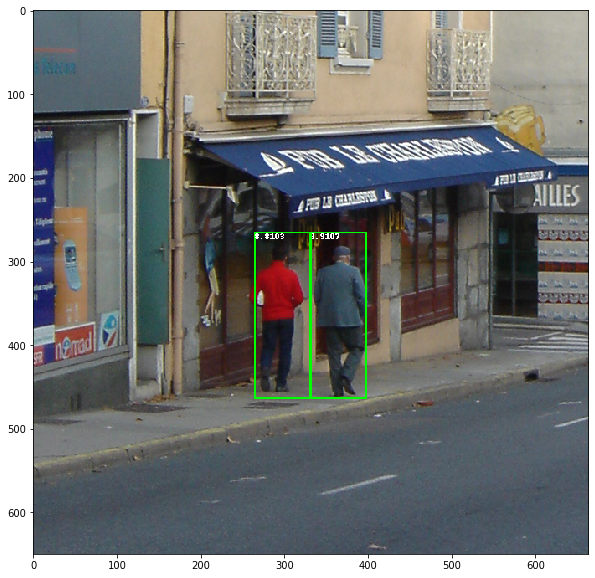

In [10]:
imagePath = 'Images/Image001.png'
bboxes, scores = detector.testImage(imagePath, applyNMS=True)
img = Image.open(imagePath)
img = drawing.drawResultsOnImage(img, bboxes, scores)
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img);

### Train

#### Extract Features of positive and negatives images

In [ ]:
if not os.path.exists(cfg.positiveFeaturesPath):
    os.makedirs(cfg.positiveFeaturesPath,)
if not os.path.exists(cfg.negativeFeaturesPath):
    os.makedirs(cfg.negativeFeaturesPath)

#Extract features for positive samples
print('Extracting features from images in '+cfg.positiveInputPath)
featureExtractor.extractAndStoreFeatures(cfg.positiveInputPath,  cfg.positiveFeaturesPath)
print('Extracting features from images in '+cfg.negativeInputPath)
#Extract features for negative samples
featureExtractor.extractAndStoreFeatures(cfg.negativeInputPath,  cfg.negativeFeaturesPath)

#### Get features for train process

In [23]:
def loadImageFeatures(featuresPath):
    print('Loading features from '+str(featuresPath))
    with open(featuresPath, 'rb') as file:
        features = pickle.load(file)
    return features

In [26]:
#List all the files .feat in the positives directory
positiveList = os.listdir(cfg.positiveFeaturesPath)
positiveList = list(filter(lambda element: '.feat' in element, positiveList))
#List all the files .feat in the negatives directory
negativeList = os.listdir(cfg.negativeFeaturesPath)
negativeList = list(filter(lambda element: '.feat' in element, negativeList))
#Count how many samples we have
positiveSamplesCount = len(positiveList)
negativeSamplesCount = len(negativeList)
samplesCount = positiveSamplesCount + negativeSamplesCount
#Load the features of the first element, to obtain the size of the feature vectors.
filepath = cfg.positiveFeaturesPath+positiveList[0]
with open(filepath, 'rb') as file:
    feats = pickle.load(file)
featuresLength = len(feats)
#Initialize the structure that we will pass to the model for training
# X will be the samples for training
# y will be the labels
X = np.zeros(shape=(samplesCount, featuresLength))
y = np.append(np.ones(shape=(1, positiveSamplesCount)),
              -1*np.ones(shape=(1, negativeSamplesCount)))

# Load all the positive feature vectors in X
count = 0
for filename in positiveList:
    filepath = cfg.positiveFeaturesPath+filename
    X[count] = loadImageFeatures(filepath)
    count += 1

# Load all the negative feature vectors in y
for filename in negativeList:
    filepath = cfg.negativeFeaturesPath+filename
    X[count] = loadImageFeatures(filepath)
    count += 1

Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001001a_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001001b_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001001c_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001001d_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001001e_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001001f_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001002a_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001002b_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001002c_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPos_0.000000_crop001002d_0.png.feat
Loading features from Features/LBP/Pedestrians/AnnotationsPo

#### Train Model

In [28]:
import pickle
from sklearn import svm
from sklearn import linear_model

In [29]:
# Train the classifier with X and y, and some given parameters
if cfg.model == 'SVM':
    print('Training SVM....')
    model = svm.LinearSVC(C=cfg.svm_C,
                            #loss='hinge',# loss
                            penalty=cfg.outputModelFile,
                            dual=cfg.svm_dual,
                            tol=cfg.svm_tol,
                            fit_intercept=cfg.svm_fit_intercept,
                            intercept_scaling=cfg.svm_intercept_scaling)
elif cfg.model == 'LogisticRegression':
    print('Training linear model....')
    model = linear_model.LogisticRegression(C=cfg.logReg_C,
                               penalty=cfg.logReg_penalty,
                               dual=cfg.logReg_dual,
                               tol=cfg.logReg_tol,
                               fit_intercept=cfg.logReg_fit_intercept,
                               intercept_scaling=cfg.logReg_intercept_scaling)
else:
    print('ERROR: Model can only be SVM or LogisticRegression')
    exit(0)

model.fit(X, y)
#Obtain the model score for the training set
print('MODEL score')
print(model.score(X, y))

#Save the model
modelDirectory, modelFilename = os.path.split(cfg.modelPath)
if not os.path.exists(modelDirectory):
    os.makedirs(modelDirectory)

with open(cfg.modelPath, 'wb') as outputModelFile:
    pickle.dump(model, outputModelFile)

Training linear model....


C:\Users\JuanLombana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MODEL score
1.0


### Evaluation

In [32]:
import pickle
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt

#Computes the overlap between two bounding boxes in the format
# [TLX, TLY, BRX, BRY]
def computeOverlap(A, B):
    #Area of first bounding box
    SA = (A[3] - A[1])*(A[2] - A[0]) # width * height
    #Area of second bounding box
    SB = (B[3] - B[1])*(B[2] - B[0]) # width * height
    #Coordinates of the intersection
    Ix1 = max(A[0], B[0])
    Iy1 = max(A[1], B[1])
    Ix2 = min(A[2], B[2])
    Iy2 = min(A[3], B[3])
    Iw = Ix2 - Ix1# Width of the intersection
    Ih = Iy2 - Iy1# Height of the intersection
    SI = max(0, Iw) * max(0, Ih)#Area of the intersection
    SU = SA + SB - SI #Area of union
    if SU > 0:
        ratio = float(SI) / float(SU)
    else:
        ratio = 0.
    return ratio

# Returns Statistics (TP, FP, FN) given annotations and detections.
def evaluateImage(annotatedBoxes, detectedBoxes, detectedBoxesScores= None):
    TP = 0
    FP = 0
    FN = 0
    if len(annotatedBoxes) == 0:
        FP = len(detectedBoxes)
        return TP, FP, FN
    if len(detectedBoxes) == 0:
        FN = len(annotatedBoxes)
        return TP, FP, FN
    #Sort the boxes by score, in descending order
    if detectedBoxesScores is not None:
        detectedBoxes = detectedBoxes[np.argsort(-detectedBoxesScores)]
    aBoxIsAlreadyDetected = [False]*len(annotatedBoxes)
    annotationsFound = 0
    for dBox in detectedBoxes:
        #See if it's a TP or a FP
        maxRatio = 0
        for idx in range(0, len(annotatedBoxes)):
            aBox = annotatedBoxes[idx]
            currentRatio = computeOverlap(dBox, aBox)
            if currentRatio > maxRatio:
                maxRatio = currentRatio

        if maxRatio > cfg.annotation_min_overlap:
            if not aBoxIsAlreadyDetected[idx]:
                TP += 1
                annotationsFound += 1
                aBoxIsAlreadyDetected[idx] = True
            else:
                FP += 1
        else:
            FP += 1
    #All those that were not detected are false negatives
    FN = len(annotatedBoxes) - annotationsFound
    return TP, FP, FN